**1. Imports and synthetic data generation**

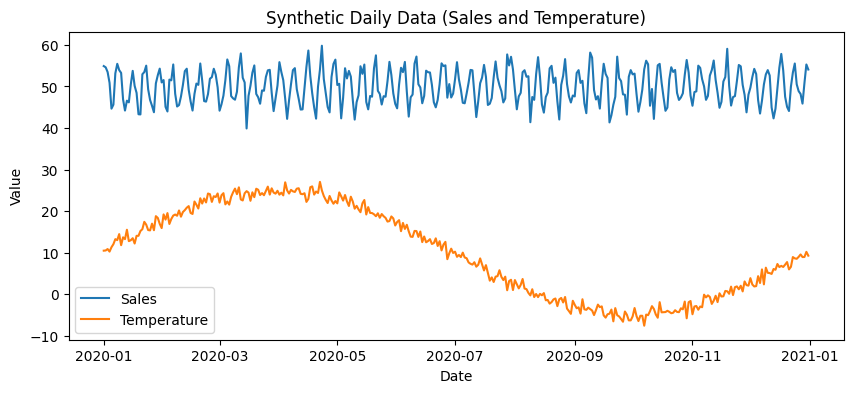

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# For reproducibility
np.random.seed(42)

# -------------------
# Generate a synthetic dataset
# -------------------
date_range = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')
n = len(date_range)

# Let's create a "sales" time series with weekly seasonality
# and a "temperature" time series with annual seasonality
# plus some random noise.
sales = 50 + 5*np.sin(2*np.pi*(date_range.dayofyear/7)) + np.random.normal(0, 2, n)
temperature = 10 + 15*np.sin(2*np.pi*(date_range.dayofyear/365)) + np.random.normal(0, 1, n)

# Build a dataframe
df = pd.DataFrame({
    'sales': sales,
    'temperature': temperature
}, index=date_range)

df.index.name = 'date'  # Name the index
df.head()

plt.figure(figsize=(10, 4))
plt.plot(df.index, df['sales'], label='Sales')
plt.plot(df.index, df['temperature'], label='Temperature')
plt.title('Synthetic Daily Data (Sales and Temperature)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

**2. Feature Engineering Functions**

In [12]:
def create_lag_features(df, target_cols, lags):
    """
    Creates lag features for the specified target columns and lag list.
    df: DataFrame with a DateTime index
    target_cols: list of column names to create lag features for
    lags: list of integers (e.g., [1, 7, 14]) 
    """
    for col in target_cols:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

def add_rolling_features(df, target_cols, windows):
    """
    Creates rolling mean and rolling std features for given columns and window sizes.
    df: DataFrame with a DateTime index
    target_cols: list of columns to create rolling stats for
    windows: list of integers (e.g., [7, 30])
    """
    for col in target_cols:
        for window in windows:
            df[f'{col}_rmean_{window}'] = df[col].rolling(window=window).mean()
            df[f'{col}_rstd_{window}'] = df[col].rolling(window=window).std()
    return df

def add_date_features(df):
    """
    Adds common date-based features like day_of_week, day_of_year, month, year.
    Assumes DataFrame index is a DateTimeIndex.
    """
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

**3. XGBoost for Time Series**

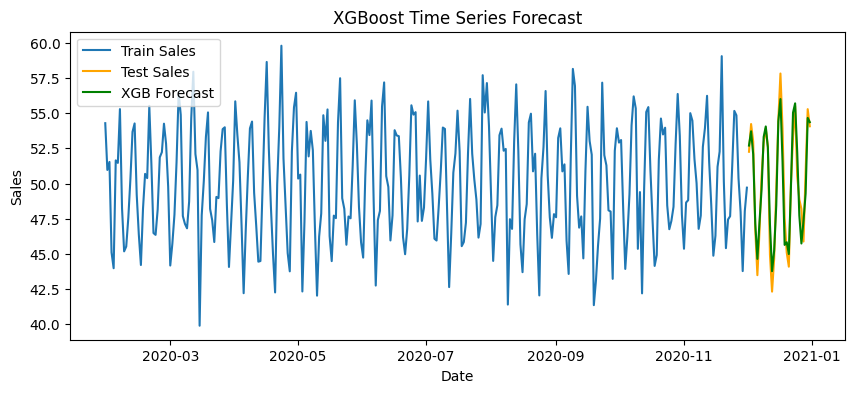

In [13]:
"""XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime."""

# 1) Make a copy of the DataFrame to avoid contaminating it

df_xgb = df.copy()

# 2) Feature Engineering: Lags, Rolling, and Date Features
df_xgb = create_lag_features(df_xgb, target_cols=['sales'], lags=[1, 7])
df_xgb = add_rolling_features(df_xgb, target_cols=['sales'], windows=[7, 30])
df_xgb = add_date_features(df_xgb)

# 3) Drop rows with NaN (from shifting/rolling)
df_xgb.dropna(inplace=True)

# 4) Prepare training and test sets
# We'll forecast the last ~30 days for demonstration
train_size = len(df_xgb) - 30
train_data = df_xgb.iloc[:train_size]
test_data = df_xgb.iloc[train_size:]

# 5) Separate features (X) and target (y)
feature_cols = [col for col in df_xgb.columns if col != 'sales']
X_train = train_data[feature_cols]
y_train = train_data['sales']
X_test = test_data[feature_cols]
y_test = test_data['sales']

# 6) Train an XGBoost Regressor
from xgboost import XGBRegressor
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)

# 7) Predict
y_pred_xgb = model_xgb.predict(X_test)

# 8) Plot the results
plt.figure(figsize=(10, 4))
plt.plot(train_data.index, y_train, label='Train Sales')
plt.plot(test_data.index, y_test, label='Test Sales', color='orange')
plt.plot(test_data.index, y_pred_xgb, label='XGB Forecast', color='green')
plt.title('XGBoost Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


**4. Prophet for Business Forecasting**

09:43:17 - cmdstanpy - INFO - Chain [1] start processing
09:43:17 - cmdstanpy - INFO - Chain [1] done processing


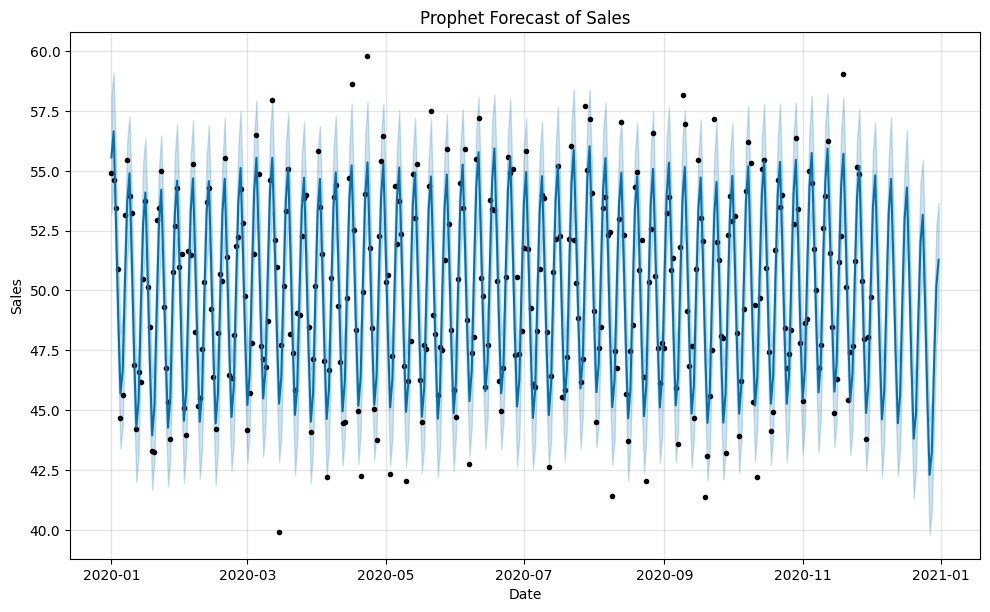

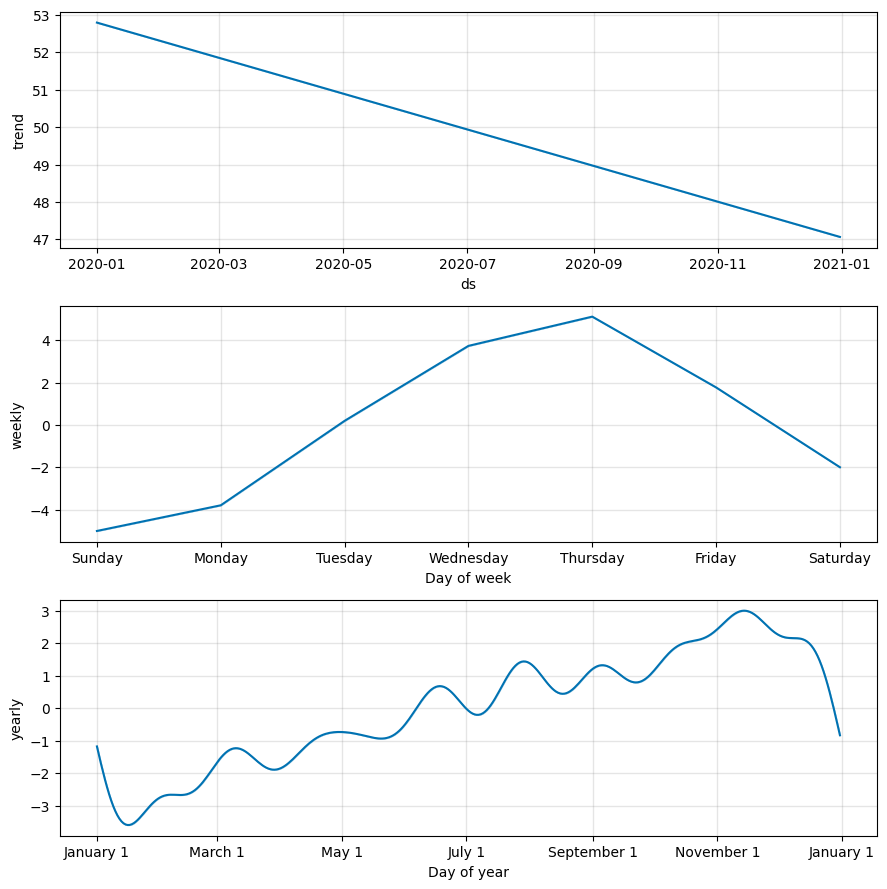

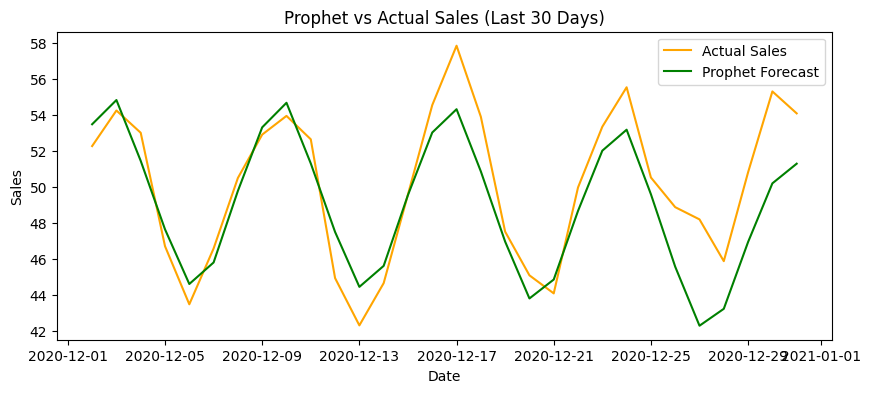

In [14]:
# First, reset any modifications from the previous cells
df_prophet = df[['sales']].reset_index()  # reset_index so 'date' becomes a normal column

# Rename columns for Prophet
df_prophet.columns = ['ds', 'y']

# Split data
prophet_train = df_prophet.iloc[:-30]  # everything except last 30 days
prophet_test = df_prophet.iloc[-30:]   # last 30 days

# Build and train the model
from prophet import Prophet

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.fit(prophet_train)

# Create future dataframe (we'll forecast just the next 30 days, 
# but we can also forecast further if we like)
future = model_prophet.make_future_dataframe(periods=30, freq='D')
forecast = model_prophet.predict(future)

# Plot forecast
fig1 = model_prophet.plot(forecast)
plt.title('Prophet Forecast of Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Optional: plot the forecast components (trend, weekly, yearly seasonality)
fig2 = model_prophet.plot_components(forecast)
plt.show()

# If we want to compare predictions to the true test data:
predicted_prophet = forecast.set_index('ds').loc[prophet_test['ds'], 'yhat']
plt.figure(figsize=(10,4))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual Sales', color='orange')
plt.plot(predicted_prophet.index, predicted_prophet, label='Prophet Forecast', color='green')
plt.title('Prophet vs Actual Sales (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

**5. Multivariate Forecasting with sktime**

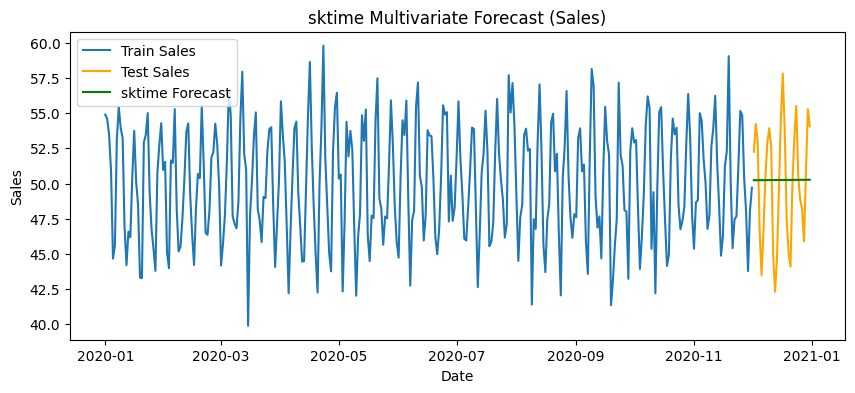

In [15]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
import warnings
warnings.filterwarnings('ignore')  # to suppress some sktime deprecation warnings

# sktime uses "long format" univariate series typically, or Hierarchical approach for multivariate.
# For a quick demonstration, let's just keep them in a DataFrame and use a MultiplexForecaster.

df_skt = df.copy()  # sktime-friendly approach

# We need to specify the forecasting horizon
# Let's do a 30-day forecast again.
y_train, y_test = temporal_train_test_split(df_skt, test_size=30)

# We'll define different forecasters for different columns
# For demonstration: sales -> Polynomial Trend, temperature -> Naive
forecaster_sales = PolynomialTrendForecaster(degree=1)
forecaster_temp = NaiveForecaster(strategy="mean")

# MultiplexForecaster can handle multiple "slots",
# but we also need to specify which columns each forecaster is responsible for.
# In practice, you might use a more advanced approach like 'ColumnEnsembleForecaster'.
from sktime.forecasting.compose import ColumnEnsembleForecaster

forecaster = ColumnEnsembleForecaster([
    ("sales_forecaster", forecaster_sales, "sales"),
    ("temperature_forecaster", forecaster_temp, "temperature")
])

# Fit the forecaster
forecaster.fit(y_train)

# Predict the next 30 days
fh = np.arange(1, 31)  # forecasting horizon: steps 1 to 30
y_pred_skt = forecaster.predict(fh)

# Plot results for "sales" only for clarity
# (You can similarly look at "temperature" or any other columns.)
plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train['sales'], label='Train Sales')
plt.plot(y_test.index, y_test['sales'], label='Test Sales', color='orange')
plt.plot(y_pred_skt.index, y_pred_skt['sales'], label='sktime Forecast', color='green')
plt.title('sktime Multivariate Forecast (Sales)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()